In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import itertools

import matplotlib.pyplot as plt
import seaborn as sb


In [2]:
results = pd.read_csv("metrics.csv")

dataf = results[results["algo"] == "datafly"]
mondr = results[results["algo"] == "mondrian"]
dataf_shuff = results[results["algo"] == "datafly_shuffled"]

In [3]:
results

,algo,no,precision,dm,cm,entropy,discern,ilm,auroc,lr_acc,hellinger,bivariate_corr
0,datafly,1,0.472531,0.466667,0.520933,0.723852,0.180107,0.166484,NaN,0.425926,0.236703,0.493245
1,datafly_shuffled,1,0.392746,0.333333,0.574457,0.802920,0.326712,0.187299,NaN,0.367725,0.174165,0.476127
2,mondrian,1,0.630650,0.866667,0.425543,0.357773,0.011453,0.138986,NaN,0.444444,0.217266,0.038500
3,datafly,2,0.401814,0.333333,0.551669,0.767857,0.256308,0.183695,NaN,0.362434,0.219427,0.492103
4,datafly_shuffled,2,0.370174,0.333333,0.572867,0.768779,0.248001,0.177843,NaN,0.370370,0.174165,0.479300
...,...,...,...,...,...,...,...,...,...,...,...,...
595,datafly_shuffled,199,0.333333,0.200000,0.586645,0.837448,0.383618,0.200000,NaN,0.391534,0.219427,0.000000
596,mondrian,199,0.590277,0.866667,0.421834,0.387351,0.021104,0.151716,NaN,0.423280,0.252361,0.019067
597,datafly,200,0.259259,0.266667,0.567038,0.811682,0.282501,0.211111,NaN,0.425926,0.248490,0.001721
598,datafly_shuffled,200,0.388683,0.333333,0.536831,0.755125,0.208323,0.185603,NaN,0.399471,0.219427,0.490936


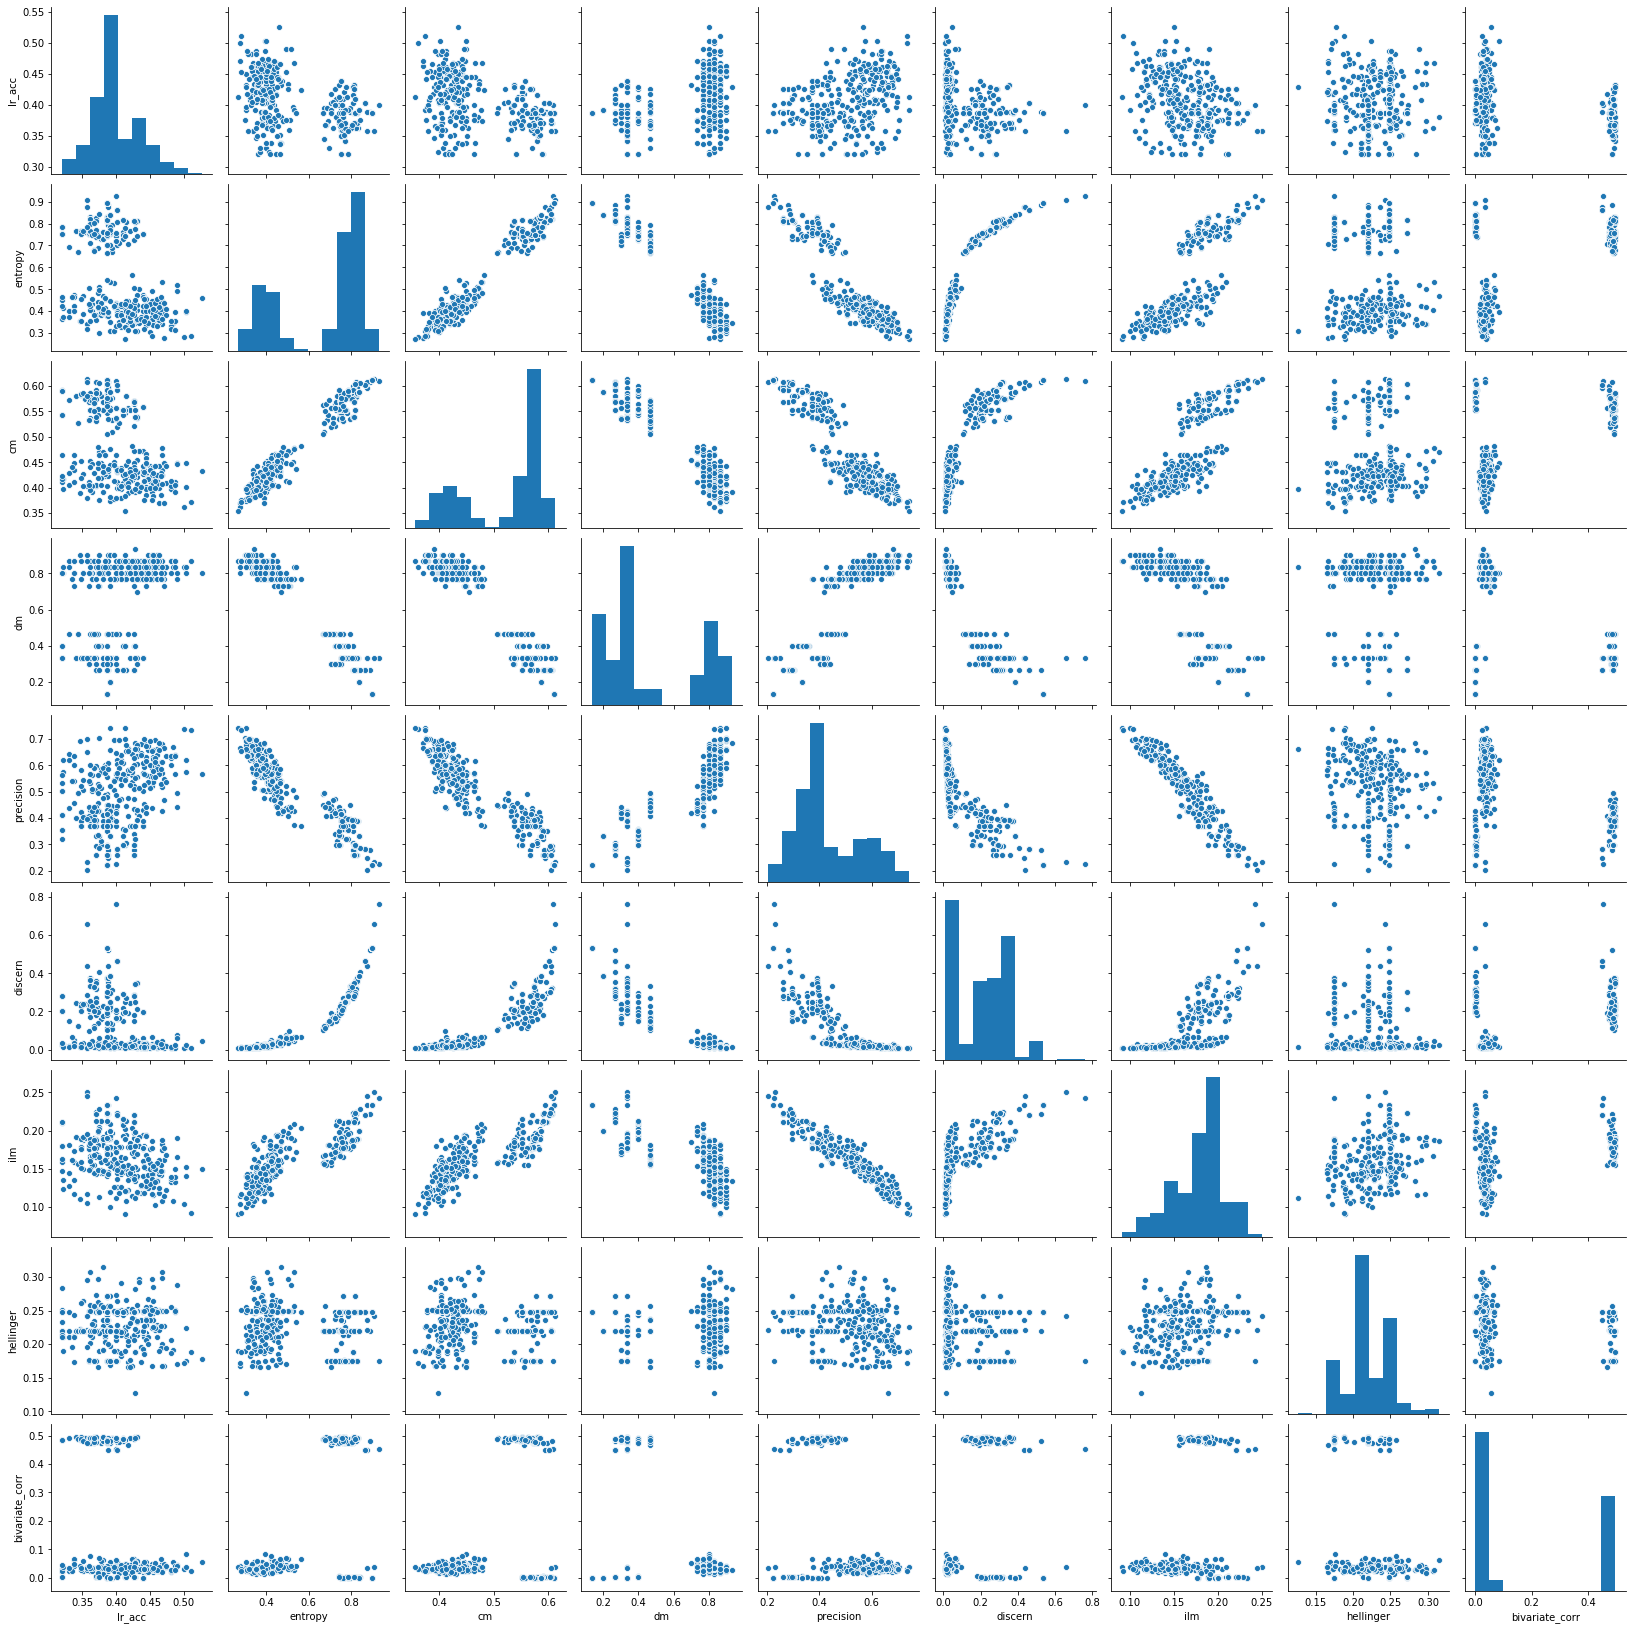

In [5]:
sb.pairplot(results[["lr_acc", "entropy", "cm", "dm", "precision", "discern", "ilm", "hellinger", "bivariate_corr"]])

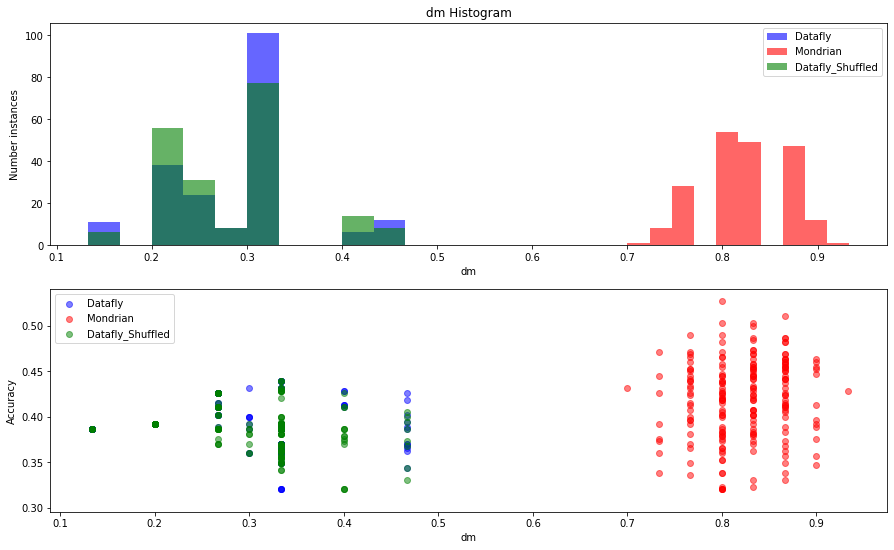

In [6]:
def plot_metric(metric):    
    fig, (ax1, ax2)= plt.subplots(2,1, figsize=(15,9))
    dataflys = results[results["algo"] == "datafly"]
    dataflys_shuff = results[results["algo"] == "datafly_shuffled"]
    mondrians = results[results["algo"] == "mondrian"]
    
    ax1.hist(dataflys[metric], label="Datafly", color="b", alpha=.6)
    ax1.hist(mondrians[metric], label="Mondrian", color="r", alpha=.6)
    ax1.hist(dataflys_shuff[metric], label="Datafly_Shuffled", color="g", alpha=.6)
    ax1.set_xlabel(metric)
    ax1.set_ylabel("Number instances")
    ax1.legend()
    ax1.set_title(f"{metric} Histogram")
    
    ax2.scatter(dataflys[metric], dataflys["lr_acc"], c="b", alpha=0.5, label="Datafly")
    ax2.scatter(mondrians[metric], mondrians["lr_acc"], c="r", alpha=0.5, label="Mondrian")
    ax2.scatter(dataflys_shuff[metric], dataflys_shuff["lr_acc"], c="g", alpha=0.5, label="Datafly_Shuffled")
    ax2.set_xlabel(metric)
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    
plot_metric("dm")

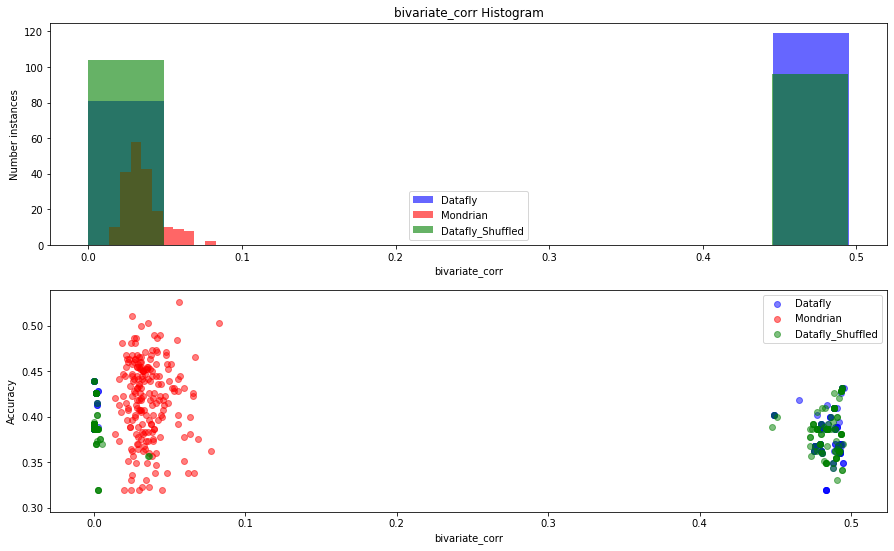

In [7]:
plot_metric("bivariate_corr")

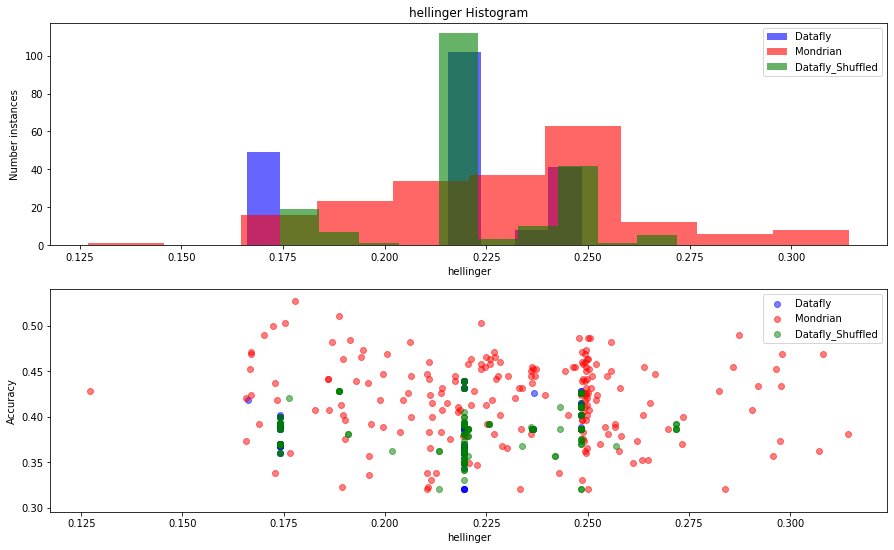

In [6]:
plot_metric("hellinger")

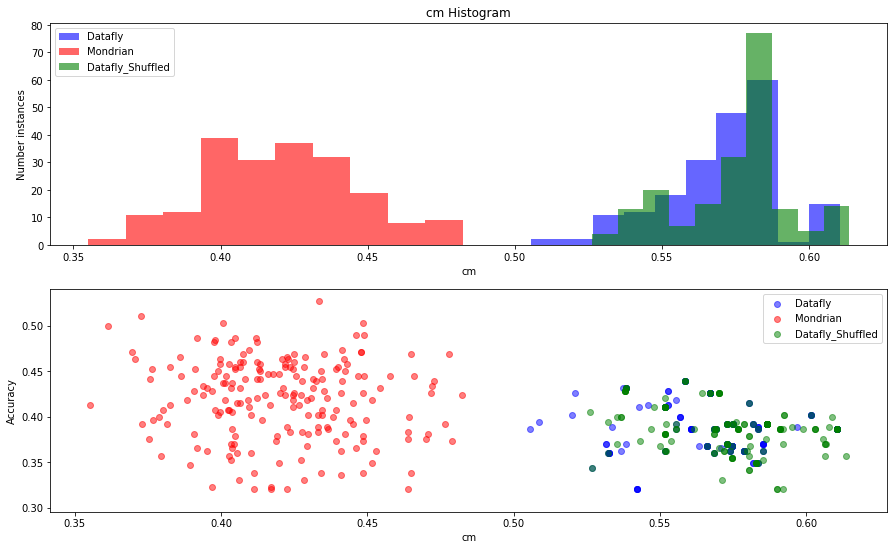

In [6]:
plot_metric("cm")

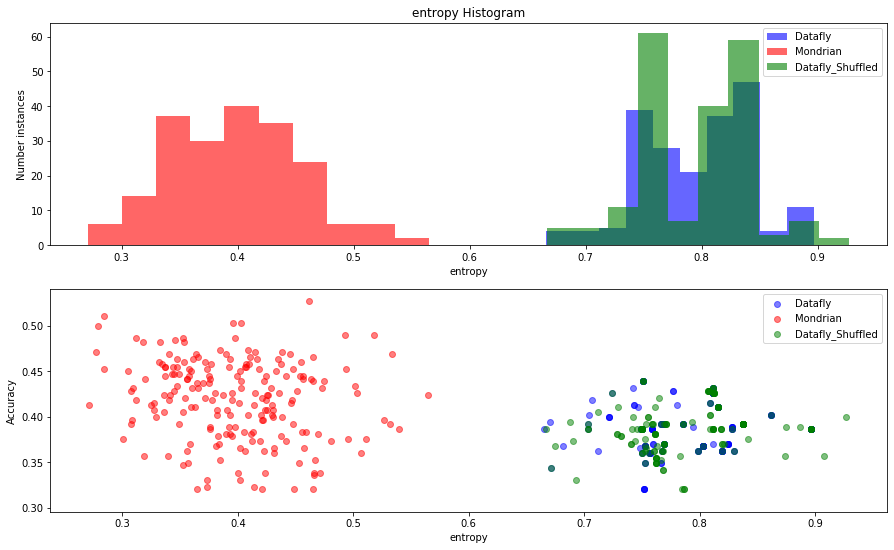

In [7]:
plot_metric("entropy")

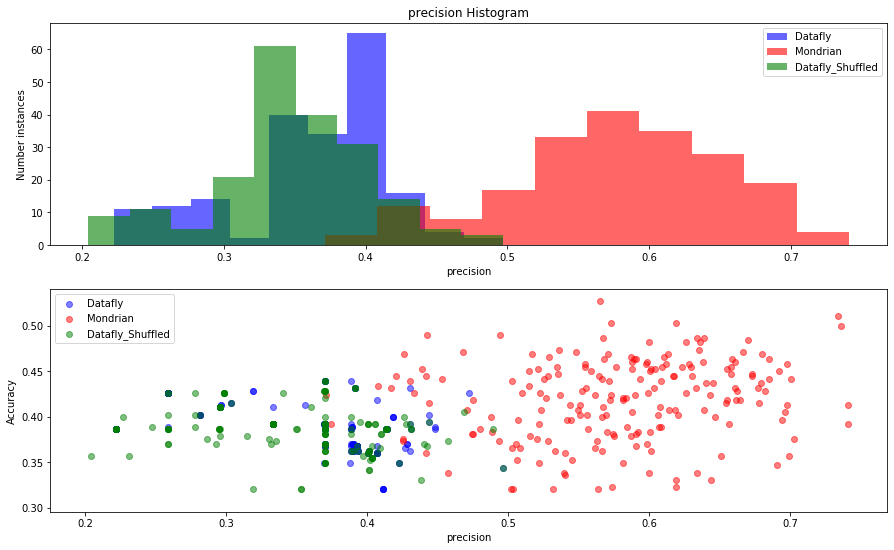

In [8]:
plot_metric("precision")

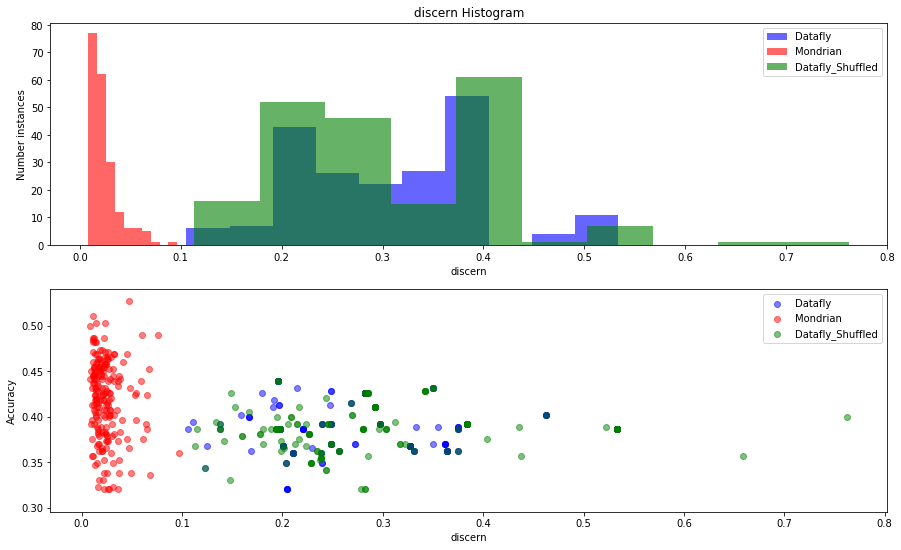

In [9]:
plot_metric("discern")

In [10]:
mondr["discern"].value_counts()

0.045479    1
0.021862    1
0.012802    1
0.017307    1
0.012859    1
           ..
0.022045    1
0.024522    1
0.032092    1
0.025462    1
0.068448    1
Name: discern, Length: 200, dtype: int64

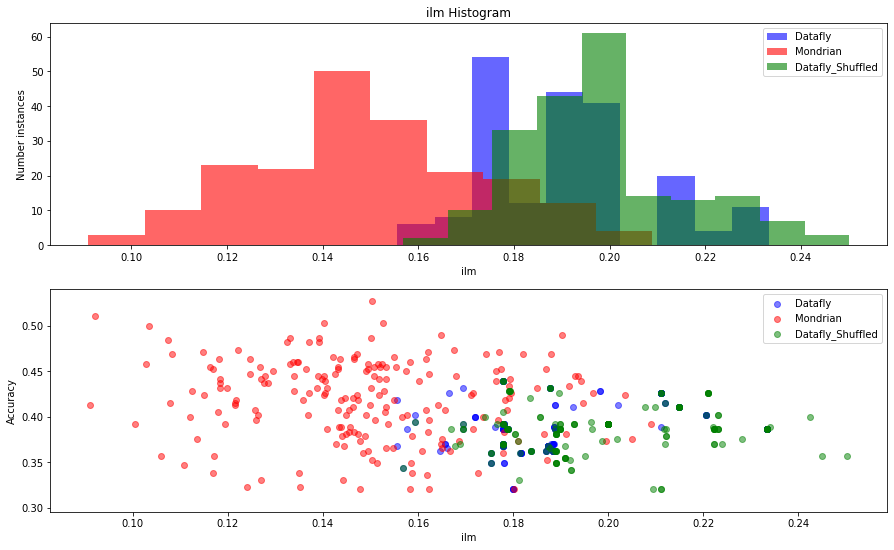

In [11]:
plot_metric("ilm")

# Plot AUROC

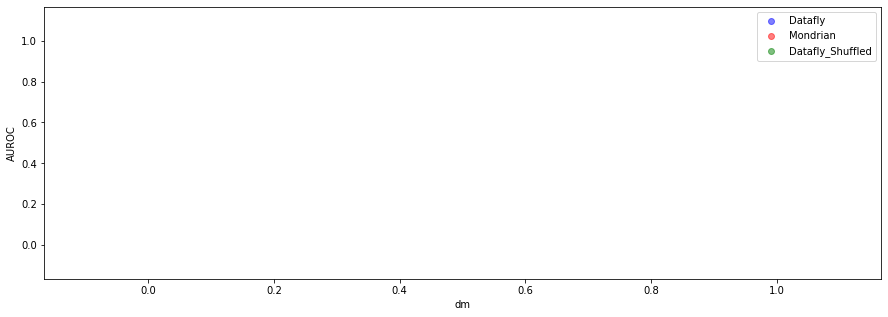

In [12]:
def plot_metric_auroc(metric):    
    fig, (ax2)= plt.subplots(1,1, figsize=(15,5))
    dataflys = results[results["algo"] == "datafly"]
    dataflys_shuff = results[results["algo"] == "datafly_shuffled"]
    mondrians = results[results["algo"] == "mondrian"]

    ax2.scatter(dataflys[metric], dataflys["auroc"], c="b", alpha=0.5, label="Datafly")
    ax2.scatter(mondrians[metric], mondrians["auroc"], c="r", alpha=0.5, label="Mondrian")
    ax2.scatter(dataflys_shuff[metric], dataflys_shuff["auroc"], c="g", alpha=0.5, label="Datafly_Shuffled")
    ax2.set_xlabel(metric)
    ax2.set_ylabel("AUROC")
    ax2.legend()
    
plot_metric_auroc("dm")

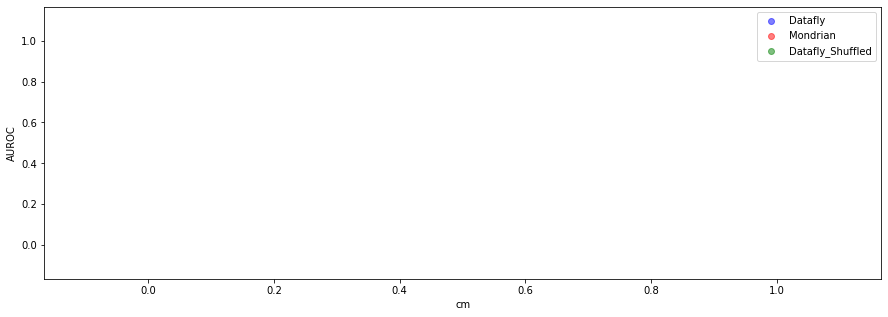

In [13]:
plot_metric_auroc("cm")

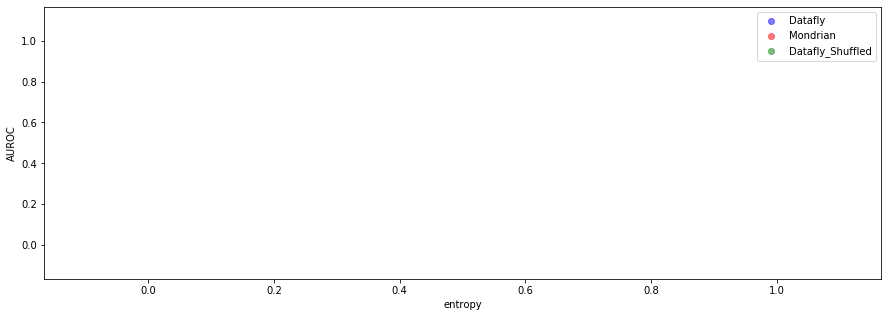

In [14]:
plot_metric_auroc("entropy")

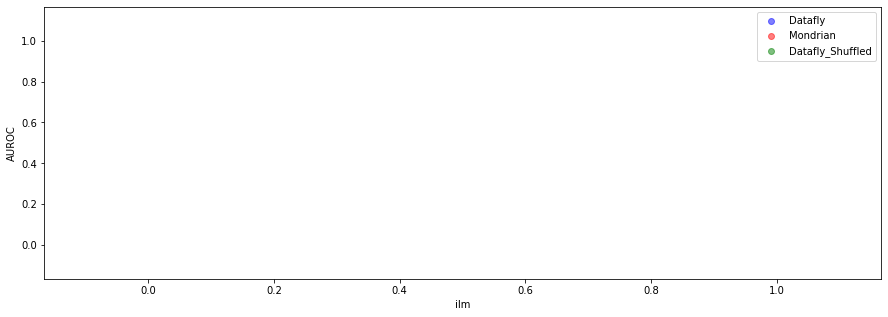

In [15]:
plot_metric_auroc("ilm")

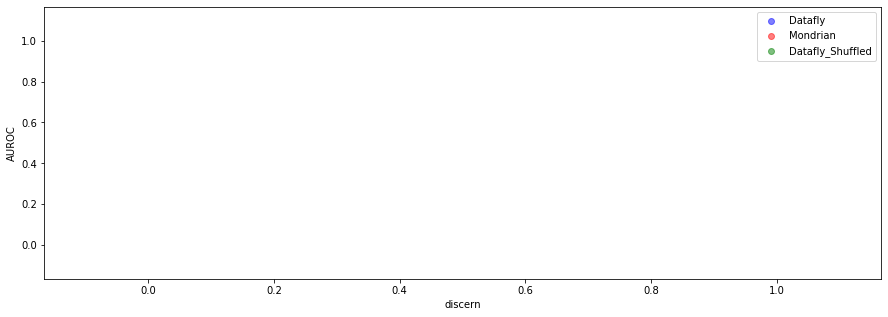

In [16]:
plot_metric_auroc("discern")

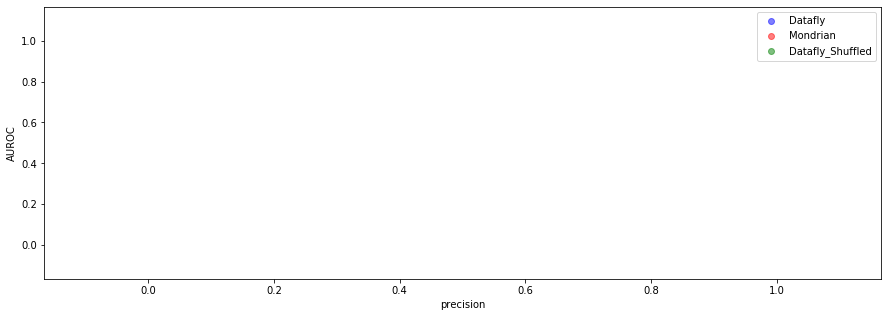

In [17]:
plot_metric_auroc("precision")

# Predicting Power

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def regress(regressor, algo_data):

    X = algo_data[regressor]
    y = algo_data["lr_acc"]

    reg = LinearRegression()
    reg.fit(X, y)

    score = reg.score(X,y)
    return reg, score

def mse(reg, attributes):
    attrs = np.array(results[attributes])
    attrs = attrs.reshape(-1,1) if len(attrs) == 1 else attrs
    y_pred = reg.predict(attrs)
    y_true = results["lr_acc"]
    mse = mean_squared_error(y_true, y_pred)
    return mse

mses = []

In [19]:
def fit_and_graph(regressor, algo_data):
    print(f"Regression on {algo_data['algo'].iloc[0]}")
    reg, score = regress([regressor], algo_data)
    coeff = reg.coef_
    intercept = reg.intercept_
    
    err = mse(reg, [regressor])
    print(f"p-value: {scipy.stats.pearsonr(algo_data[regressor],algo_data['lr_acc'])[1]}")
    print(f"R2 Score: {score}")
    print(f"MSE: {err}")
    print(f"Coeffs: {coeff}")
    print(f"Intercept: {intercept}")
    
    x = np.linspace(0,1,100)
    l = coeff*x + intercept
    
    algo_data.plot.scatter(regressor, "lr_acc", figsize=(15,6), grid=True, 
                           title=f"Linear regression of the {regressor}({algo_data['algo'].iloc[0]})")
            
    plt.plot(x,l)
    


### Entropy

Regression on datafly
p-value: 0.08993359607737772
R2 Score: 0.014454234097159957
MSE: 0.002035855057746143
Coeffs: [0.06004087]
Intercept: 0.33933174806993277

Regression on mondrian
p-value: 0.00795200992707952
R2 Score: 0.03503814581667597
MSE: 0.0015207942548047244
Coeffs: [-0.14705931]
Intercept: 0.47741433633161395

Regression on datafly_shuffled
p-value: 0.0009625653615565663
R2 Score: 0.05368525975194782
MSE: 0.0028409431461663593
Coeffs: [0.10520598]
Intercept: 0.3032113046306717


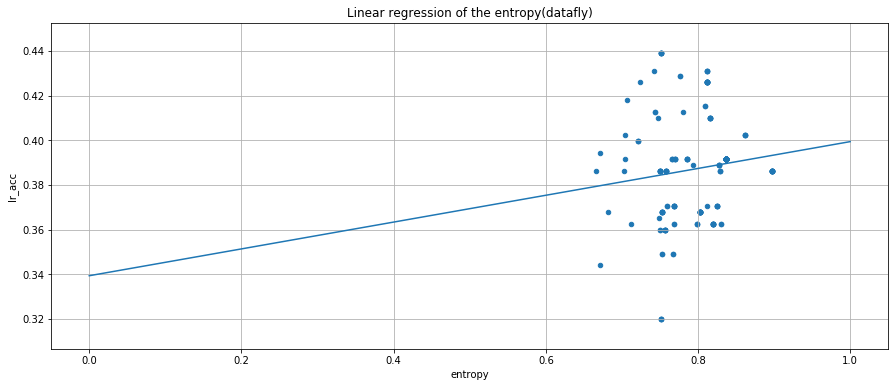

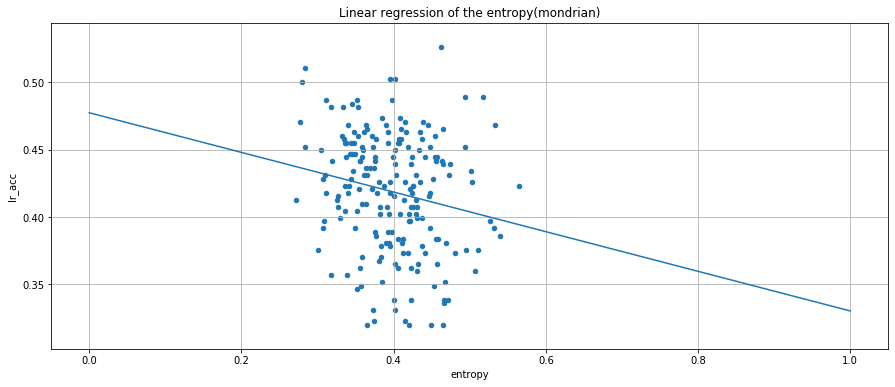

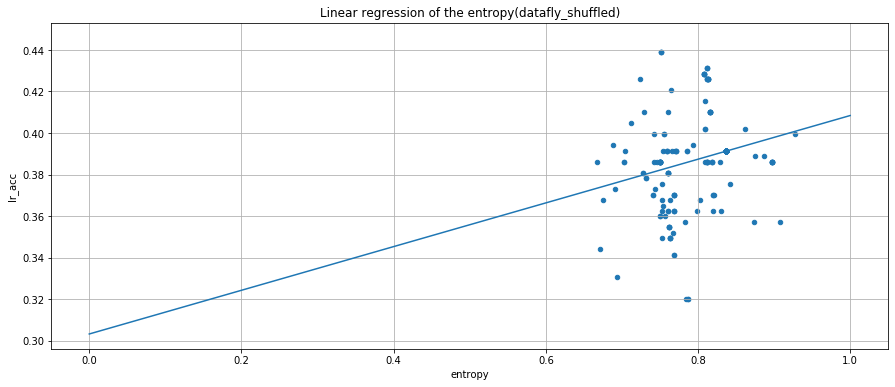

In [20]:
fit_and_graph("entropy", dataf)
print()
fit_and_graph("entropy", mondr)
print()
fit_and_graph("entropy", dataf_shuff)

### Classification Metric

Regression on datafly
p-value: 0.5418220681890555
R2 Score: 0.00188264004924521
MSE: 0.0011774191222304288
Coeffs: [-0.05010622]
Intercept: 0.41579778487578745

Regression on mondrian
p-value: 0.12747623172500797
R2 Score: 0.011692918680706208
MSE: 0.0009814968494381248
Coeffs: [-0.18700493]
Intercept: 0.49753635205531227

Regression on datafly_shuffled
p-value: 9.518095478190138e-05
R2 Score: 0.07421408229776538
MSE: 0.0010786003020277594
Coeffs: [-0.31331938]
Intercept: 0.5675068972843873


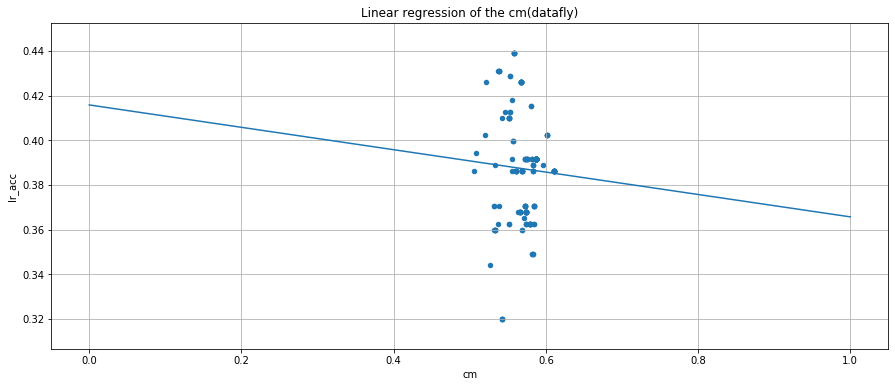

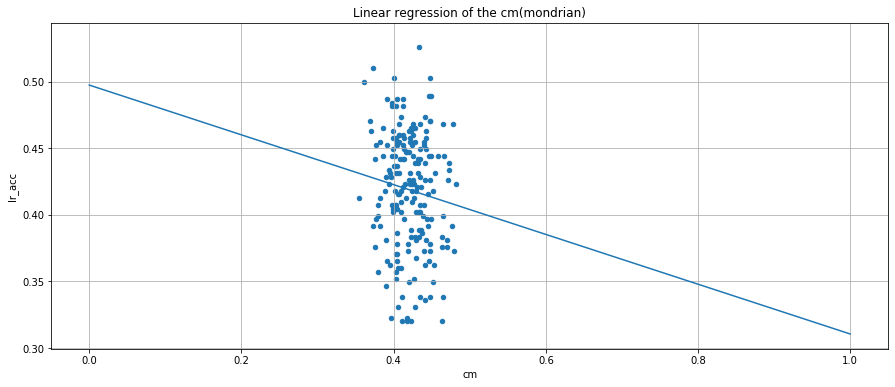

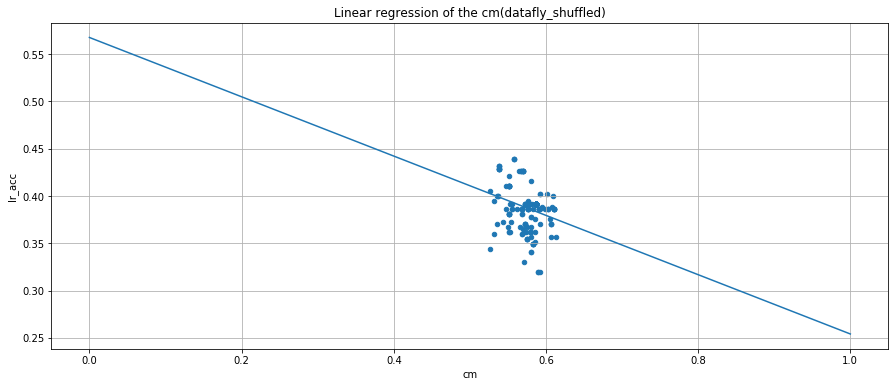

In [21]:
fit_and_graph("cm", dataf)
print()
fit_and_graph("cm", mondr)
print()
fit_and_graph("cm", dataf_shuff)

### DM

Regression on datafly
p-value: 0.019081916103825435
R2 Score: 0.027434090827795132
MSE: 0.0021082340444068164
Coeffs: [-0.05015709]
Intercept: 0.402112633249964

Regression on mondrian
p-value: 0.09402665682047542
R2 Score: 0.014097311229920084
MSE: 0.001780216831441922
Coeffs: [0.12041144]
Intercept: 0.3198436369359572

Regression on datafly_shuffled
p-value: 0.0003367269162186634
R2 Score: 0.06301062314336403
MSE: 0.0026330964322088648
Coeffs: [-0.0718129]
Intercept: 0.40776954400837795


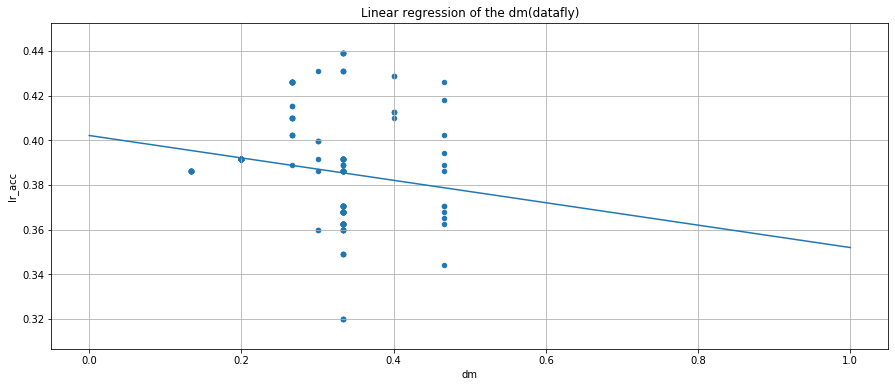

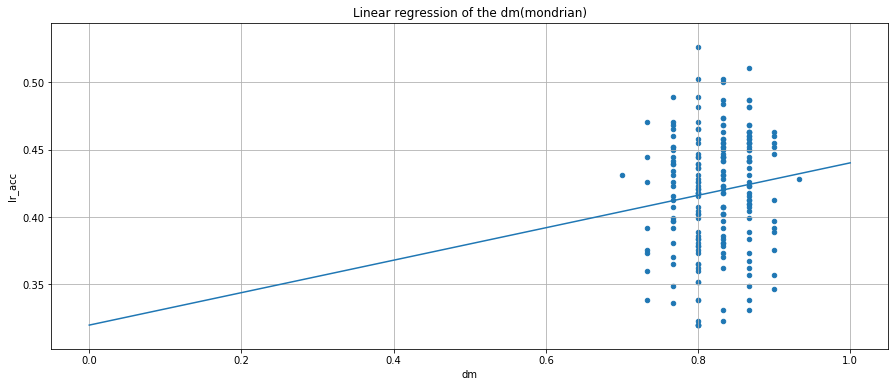

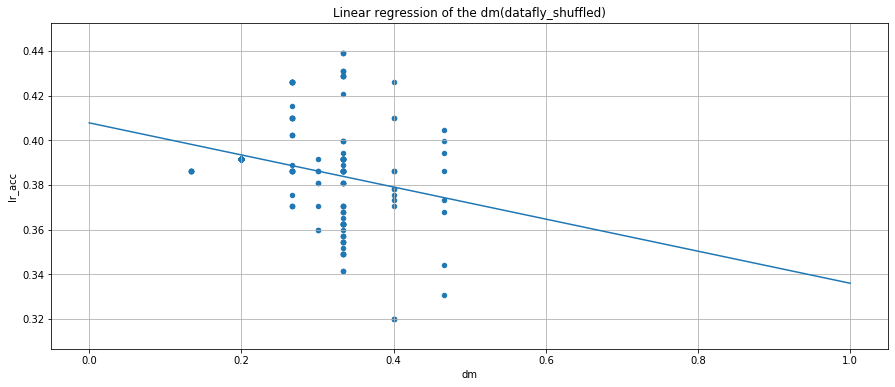

In [22]:
fit_and_graph("dm", dataf)
print()
fit_and_graph("dm", mondr)
print()
fit_and_graph("dm", dataf_shuff)

### Precision


Regression on datafly
p-value: 2.1259353563240227e-10
R2 Score: 0.18476668267210372
MSE: 0.002777608684798553
Coeffs: [-0.17949535]
Intercept: 0.4513344607629391

Regression on mondrian
p-value: 0.01307210800297042
R2 Score: 0.03070487877701999
MSE: 0.001101964021269775
Coeffs: [0.10219127]
Intercept: 0.359854751267442

Regression on datafly_shuffled
p-value: 0.00048619062943205184
R2 Score: 0.05974918290157338
MSE: 0.0020021488840924724
Coeffs: [-0.09866632]
Intercept: 0.4213525184484392


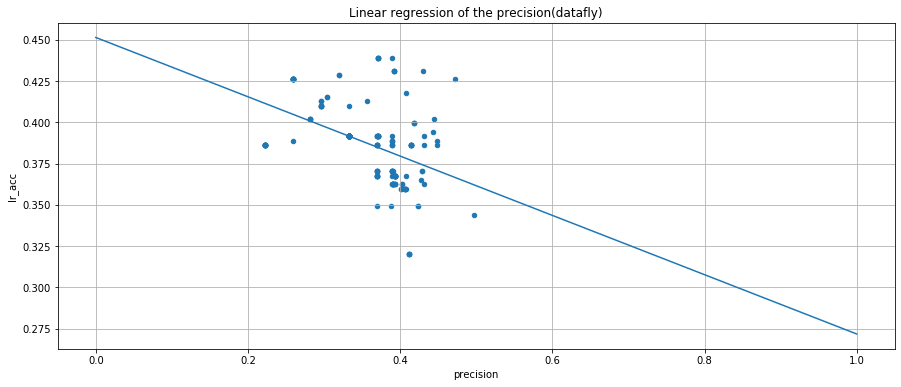

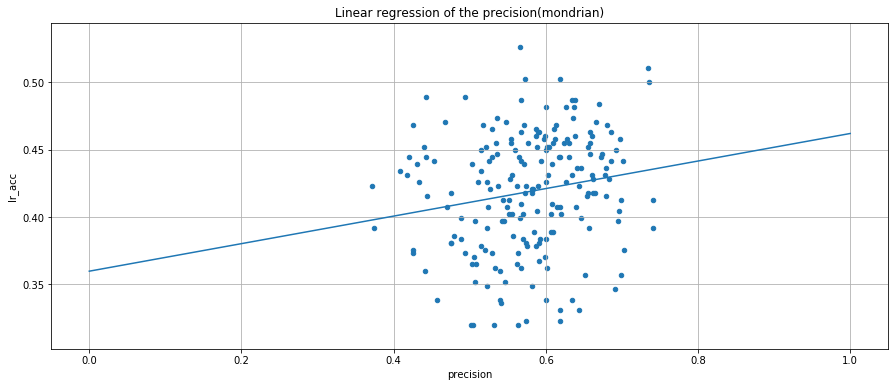

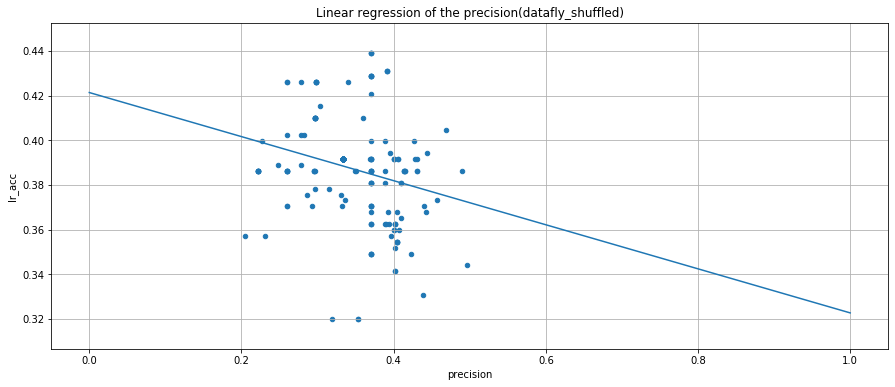

In [23]:
fit_and_graph("precision", dataf)
print()
fit_and_graph("precision", mondr)
print()
fit_and_graph("precision", dataf_shuff)


### Discernability

Regression on datafly
p-value: 0.6333240726683311
R2 Score: 0.0011516360742567233
MSE: 0.0013750506932746793
Coeffs: [0.00830329]
Intercept: 0.38465205147116865

Regression on mondrian
p-value: 0.04738677571769082
R2 Score: 0.019709869333135233
MSE: 0.007901734131223338
Coeffs: [-0.44083031]
Intercept: 0.42958091767382056

Regression on datafly_shuffled
p-value: 0.03125199555439254
R2 Score: 0.023215039705683505
MSE: 0.0015493189244082505
Coeffs: [0.03297744]
Intercept: 0.37713621660900043


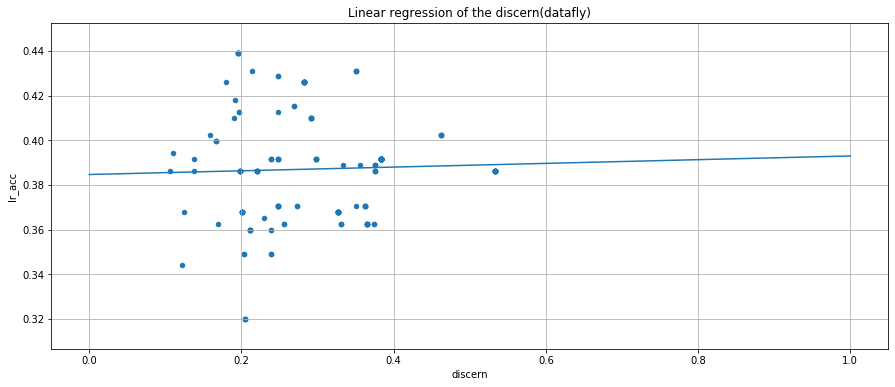

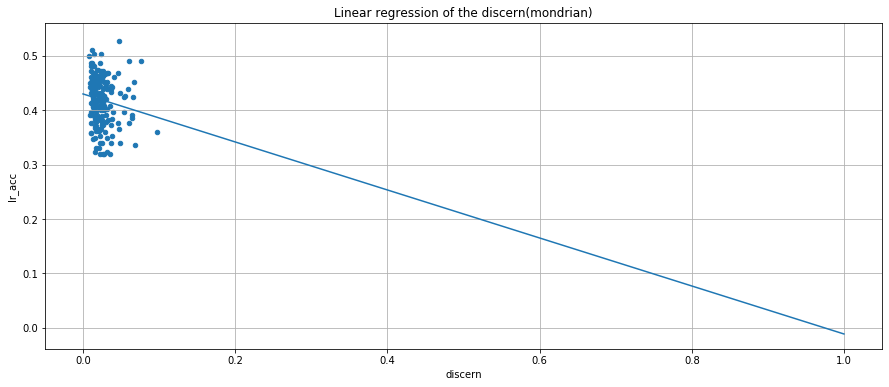

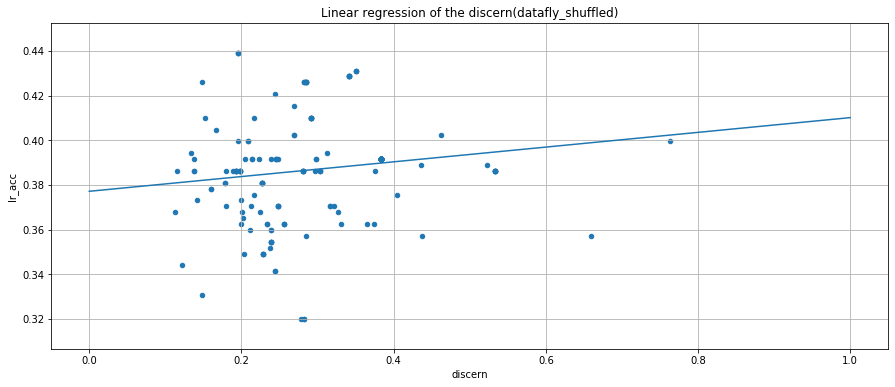

In [24]:
fit_and_graph("discern", dataf)
print()
fit_and_graph("discern", mondr)
print()
fit_and_graph("discern", dataf_shuff)

### Information Loss Metric

Regression on datafly
p-value: 1.4989892322539896e-05
R2 Score: 0.09051606191735007
MSE: 0.0018521762288289966
Coeffs: [0.41487763]
Intercept: 0.3079187912171766

Regression on mondrian
p-value: 0.10022021049845801
R2 Score: 0.013587948809528627
MSE: 0.0013337002024306106
Coeffs: [-0.21763358]
Intercept: 0.4513461407500762

Regression on datafly_shuffled
p-value: 0.16188802487258838
R2 Score: 0.009857376153221242
MSE: 0.00147685717432754
Coeffs: [0.12818473]
Intercept: 0.36170305619744525


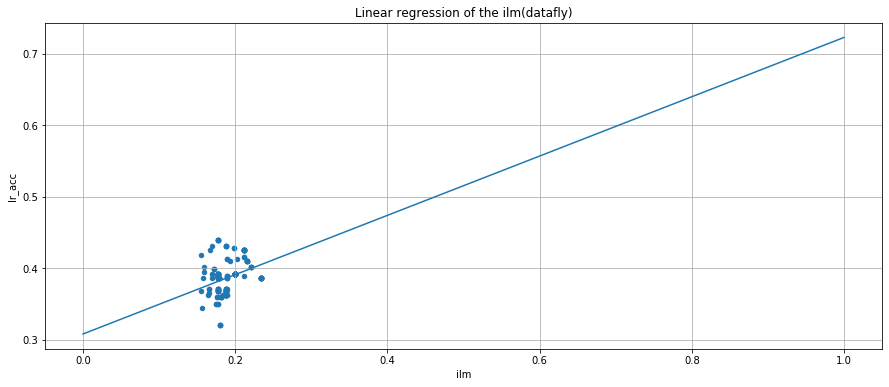

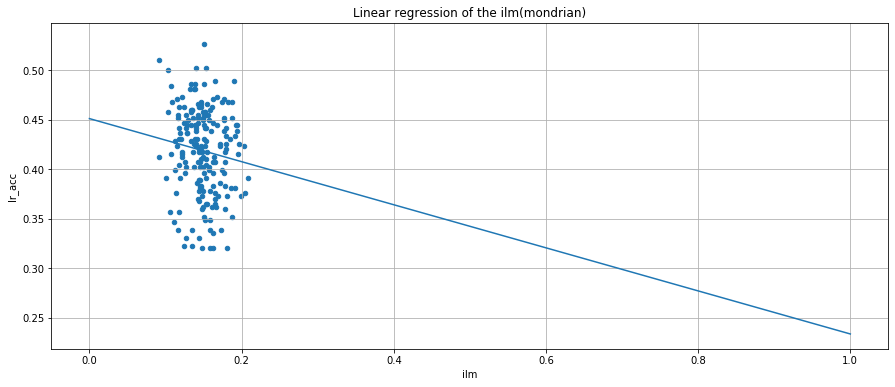

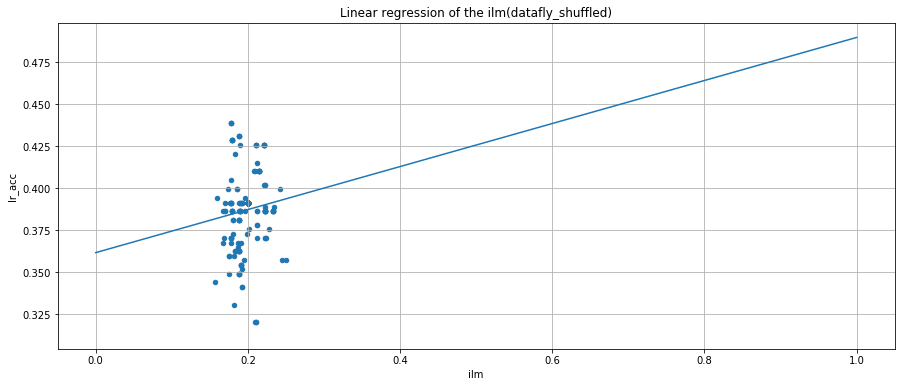

In [25]:
fit_and_graph("ilm", dataf)
print()
fit_and_graph("ilm", mondr)
print()
fit_and_graph("ilm", dataf_shuff)

### Multiple Metrics

In [26]:
metrics = ["entropy", "cm", "dm", "precision", "discern", "ilm"]

res = []
for i in range(1,6):
    
    for comb in itertools.combinations(metrics, i):
        
        ms = list(comb)
        for alg in [mondr, dataf_shuff, dataf]:
            name = alg["algo"].iloc[0] 
            reg, score = regress(ms, alg)
            err = mse(reg, ms)
            p_val = scipy.stats.pearsonr(alg[ms[0]], alg['lr_acc'])[1] if i == 1 else None
            res.append((str(ms), name, p_val, score, err))

            
df = pd.DataFrame(res, columns=["metrics", "algo", "p_value", "R2_score", "MSE_error"])
df = df.set_index(["metrics", "algo"])
df.head(20)

p_value  R2_score  MSE_error
metrics           algo                                               
['entropy']       mondrian          7.952010e-03  0.035038   0.001521
                  datafly_shuffled  9.625654e-04  0.053685   0.002841
                  datafly           8.993360e-02  0.014454   0.002036
['cm']            mondrian          1.274762e-01  0.011693   0.000981
                  datafly_shuffled  9.518095e-05  0.074214   0.001079
                  datafly           5.418221e-01  0.001883   0.001177
['dm']            mondrian          9.402666e-02  0.014097   0.001780
                  datafly_shuffled  3.367269e-04  0.063011   0.002633
                  datafly           1.908192e-02  0.027434   0.002108
['precision']     mondrian          1.307211e-02  0.030705   0.001102
                  datafly_shuffled  4.861906e-04  0.059749   0.002002
                  datafly           2.125935e-10  0.184767   0.002778
['discern']       mondrian          4.738678e-02  0.019710   0.007902
                  datafly_shuffled  3.125200e-02  0.023215   0.001549
                  datafly           6.333241e-01  0.001152   0.001375
['ilm']           mondrian          1.002202e-01  0.013588   0.001334
                  datafly_shuffled  1.618880e-01  0.009857   0.001477
                  datafly           1.498989e-05  0.090516   0.001852
['entropy', 'cm'] mondrian                   NaN  0.038525   0.001487
                  datafly_shuffled           NaN  0.348131   0.001304